# 'Niner' analysis

In [1]:
import os, pickle
import numpy as np
import pandas as pd   # module to work with data in DataFrames.
import seaborn as sns  # module to plot DataFrames in an easy way
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import interpolate

In [2]:
# seaborn comes with default presets (called 'contents') for figure's aesthetics, 
# such as the font size, figure size etc. 
#sns.set_context('talk') # try: 'talk', 'poster', 'notebook'

## Get the result files

In [3]:
# Get current result files.
result_dir = Path('../nines/results').absolute()
result_file_names = os.listdir(result_dir)
result_file_names = list(filter(lambda name: str.startswith(name, 'result'), result_file_names))

single_result_files_paths = []
for name in result_file_names:
    single_result_files_paths.append(result_dir / name)

single_result_files_paths

[WindowsPath('c:/Users/muehlefeldt/Documents/git/PerceptionAndImageQuality/analysis/../nines/results/results_erdem.csv'),
 WindowsPath('c:/Users/muehlefeldt/Documents/git/PerceptionAndImageQuality/analysis/../nines/results/results_savas.csv'),
 WindowsPath('c:/Users/muehlefeldt/Documents/git/PerceptionAndImageQuality/analysis/../nines/results/result_20220118-182237_max.csv'),
 WindowsPath('c:/Users/muehlefeldt/Documents/git/PerceptionAndImageQuality/analysis/../nines/results/result_20220119-161616_cs.csv')]

Write result files to dataframe

In [4]:
df = pd.DataFrame()
for index, path in enumerate(single_result_files_paths):
    print(index, path)
    df_tmp = pd.read_csv(path)
    df_tmp['observer'] = index
    df = pd.concat((df, df_tmp))

df.columns = ['test_image', '0', '1', '2', '3', '4', '5', '6', '7', '8', 'choosen', 'observer']

df


0 c:\Users\muehlefeldt\Documents\git\PerceptionAndImageQuality\analysis\..\nines\results\results_erdem.csv
1 c:\Users\muehlefeldt\Documents\git\PerceptionAndImageQuality\analysis\..\nines\results\results_savas.csv
2 c:\Users\muehlefeldt\Documents\git\PerceptionAndImageQuality\analysis\..\nines\results\result_20220118-182237_max.csv
3 c:\Users\muehlefeldt\Documents\git\PerceptionAndImageQuality\analysis\..\nines\results\result_20220119-161616_cs.csv


,test_image,0,1,2,3,4,5,6,7,8,choosen,observer
0,H6_recolor.BMP,0.6,1.00,1.47,1.95,2.45,2.97,3.50,4.05,4.62,1.95,0
1,I08_recolor.BMP,0.6,1.00,1.51,2.05,2.62,3.21,3.83,4.48,5.16,5.16,0
2,H18_recolor.BMP,0.6,1.00,1.37,1.74,2.10,2.46,2.80,3.15,3.48,2.10,0
3,H22_recolor.BMP,0.6,1.00,1.33,1.64,1.94,2.22,2.48,2.73,2.95,2.22,0
4,I22_recolor.BMP,0.6,1.00,1.32,1.62,1.89,2.15,2.39,2.60,2.80,0.60,0
...,...,...,...,...,...,...,...,...,...,...,...,...
40,I22_recolor.BMP,0.6,1.00,1.32,1.62,1.89,2.15,2.39,2.60,2.80,2.60,3
41,I23_recolor.BMP,0.6,0.68,0.76,0.84,0.92,1.00,1.08,1.15,1.22,0.60,3
42,H6_recolor.BMP,0.6,1.00,1.47,1.95,2.45,2.97,3.50,4.05,4.62,3.50,3
43,H15_recolor.BMP,0.6,1.00,1.32,1.61,1.88,2.14,2.37,2.58,2.77,1.00,3


# Sanity checks
We expect 30 historic and 15 modern images used during tests.
Only responses from [0, 9] accepted.

In [5]:
# sanity checks: how many groups do you expect per categorical variable?
assert len(df['test_image'].unique()) == 30 + 15
#assert max(df['response'].unique()) <= 9
#assert min(df['response'].unique()) >= 0

# Check number of observers.
assert len(df['observer'].unique()) == len(result_file_names)

In [6]:
df['test_image'] = [s.split('_')[0] for s in df['test_image'].tolist()]
df = df.sort_values(by='test_image', ascending=True, key=lambda col: [int(img[1:]) for img in col])

In [7]:
df

,test_image,0,1,2,3,4,5,6,7,8,choosen,observer
7,H0,0.6,1.0,1.42,1.84,2.27,2.70,3.14,3.58,4.03,3.14,0
3,H0,0.6,1.0,1.42,1.84,2.27,2.70,3.14,3.58,4.03,0.60,3
36,H0,0.6,1.0,1.42,1.84,2.27,2.70,3.14,3.58,4.03,1.42,1
3,H0,0.6,1.0,1.42,1.84,2.27,2.70,3.14,3.58,4.03,0.60,2
36,I01,0.6,1.0,1.70,2.47,3.31,4.23,5.23,6.29,7.44,1.70,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18,H28,0.6,1.0,1.40,1.80,2.20,2.60,2.99,3.39,3.79,1.00,1
43,H29,0.6,1.0,1.36,1.72,2.06,2.39,2.72,3.03,3.34,2.06,1
9,H29,0.6,1.0,1.36,1.72,2.06,2.39,2.72,3.03,3.34,1.36,0
5,H29,0.6,1.0,1.36,1.72,2.06,2.39,2.72,3.03,3.34,2.72,3


In [8]:
max_factor = np.ceil(max(df[[str(i) for i in range(9)]].max(axis=0)))
max_factor

8.0

### Devide dataframe into historic and modern images
And verify result.

In [9]:
df_historic = df[df['test_image'].str.startswith('H')]
df_modern = df[df['test_image'].str.startswith('I')]

assert len(df_historic['test_image'].unique()) == 30
assert len(df_modern['test_image'].unique()) == 15

### Historic plots

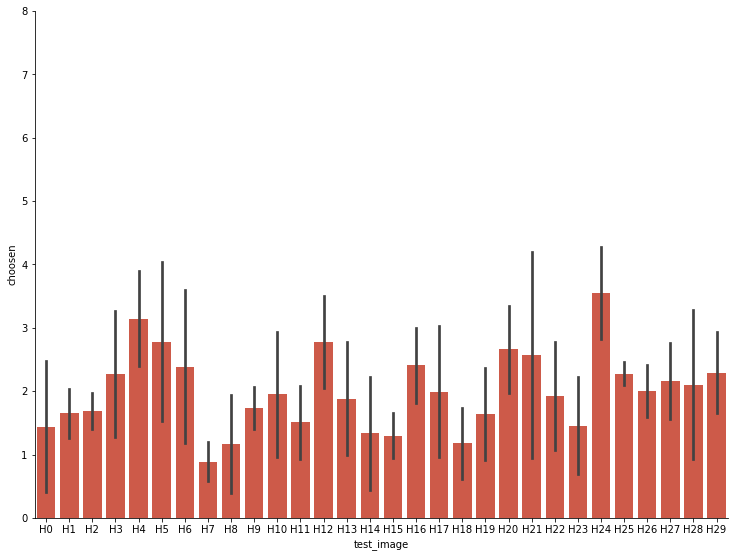

In [11]:
g = sns.catplot(x='test_image', y='choosen', data=df_historic,
                kind='bar', ci='sd', color='#e34a33')

g.fig.set_size_inches(11.7, 8.27)

g.set(ylim = (0,max_factor))
sns.despine()


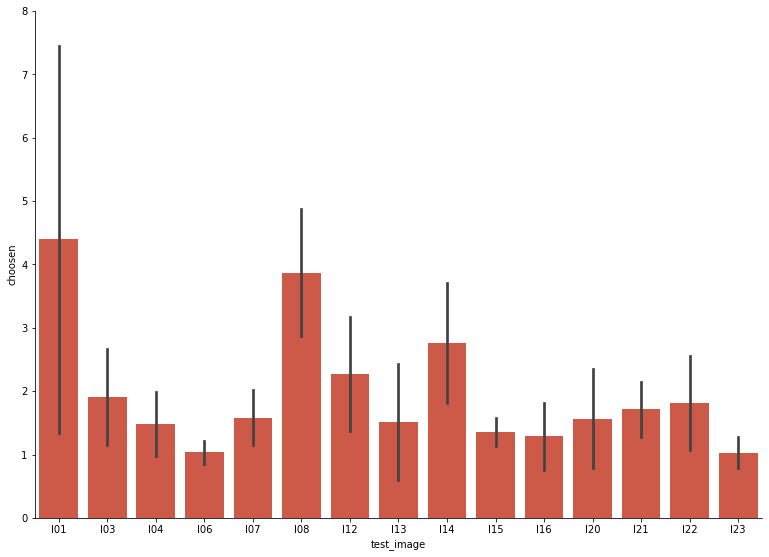

In [12]:
g = sns.catplot(x='test_image', y='choosen', data=df_modern,
                kind='bar', ci='sd', color='#e34a33')

g.fig.set_size_inches(11.7, 8.27)

g.set(ylim = (0,max_factor))
sns.despine()
